# Dictionary and Clustering Algorithm Comparison

**Team:** Seongmin Hwang, Marion SCHMITT, Seungwon Jeon

---

## Objective

1. Compare three dictionary construction methods (A, B, C)
2. Compare three clustering algorithms (K-Means, Hierarchical, DBSCAN)
3. Identify optimal combinations through systematic evaluation

**Input Files:**
- `bias_scores_method1.csv` (Method A: N-gram CountVectorizer)
- `bias_scores_method2.csv` (Method B: TF-IDF lexical_units)
- `bias_scores_method3.csv` (Method C: N-gram TF-IDF)
- `influence_data.csv` (Influence scores)

**Output Files:**
- `clustering_results.csv`
- `comparison_metrics.csv`
- Multiple visualization PNG files

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 100
sns.set_style('whitegrid')

print("✓ Libraries loaded successfully")

✓ Libraries loaded successfully


# PART 1: Load and Merge Data

In [2]:
# Load all data files
df_A = pd.read_csv('bias_scores_method1.csv')
df_B = pd.read_csv('bias_scores_method2.csv')
df_C = pd.read_csv('bias_scores_method3.csv')
df_inf = pd.read_csv('influence_data.csv')

print("Data loaded:")
print(f"  Method A: {len(df_A)} media outlets")
print(f"  Method B: {len(df_B)} media outlets")
print(f"  Method C: {len(df_C)} media outlets")
print(f"  Influence: {len(df_inf)} media outlets")

# Remove BOM if present
for df in [df_A, df_B, df_C, df_inf]:
    df.columns = df.columns.str.replace('\ufeff', '')

print("\nColumn names:")
print(f"  Method A: {df_A.columns.tolist()}")
print(f"  Method B: {df_B.columns.tolist()}")
print(f"  Method C: {df_C.columns.tolist()}")
print(f"  Influence: {df_inf.columns.tolist()}")

Data loaded:
  Method A: 18 media outlets
  Method B: 18 media outlets
  Method C: 18 media outlets
  Influence: 18 media outlets

Column names:
  Method A: ['언론사', 'Bias_Score_A']
  Method B: ['언론사', 'Bias_Score_B']
  Method C: ['언론사', 'Bias_Score_C']
  Influence: ['언론사', 'Influence_Score']


In [3]:
# Merge all data
df_all = df_A.merge(df_B, on='언론사', how='inner')
df_all = df_all.merge(df_C, on='언론사', how='inner')
df_all = df_all.merge(df_inf, on='언론사', how='inner')

print(f"\n✓ Merged dataset: {len(df_all)} media outlets")
print(f"\nColumns: {df_all.columns.tolist()}")
print("\nFirst 5 rows:")
print(df_all.head())

# Data validation
print("\n=== DATA VALIDATION ===")
print(f"Any missing values: {df_all.isnull().any().any()}")
print(f"\nMedia outlets: {sorted(df_all['언론사'].tolist())}")
print(f"\n✓ 조선일보 included: {'조선일보' in df_all['언론사'].values}")


✓ Merged dataset: 18 media outlets

Columns: ['언론사', 'Bias_Score_A', 'Bias_Score_B', 'Bias_Score_C', 'Influence_Score']

First 5 rows:
   언론사  Bias_Score_A  Bias_Score_B  Bias_Score_C  Influence_Score
0  KBS      0.064295     26.806558      0.059977         1.878760
1  MBC      0.150874     27.624324      0.142237         1.796536
2  OBS      0.022094     26.781228      0.022094        -0.235616
3  SBS      0.072830     30.194996      0.072830         1.523115
4  YTN      0.077037     29.702769      0.070831         0.979956

=== DATA VALIDATION ===
Any missing values: False

Media outlets: ['KBS', 'MBC', 'OBS', 'SBS', 'YTN', '경향신문', '국민일보', '내일신문', '동아일보', '문화일보', '서울신문', '세계일보', '시사IN', '아시아투데이', '조선일보', '중앙일보', '한겨레', '한국일보']

✓ 조선일보 included: True


# PART 2: Dictionary Method Comparison

## 2.1 Correlation Analysis

In [4]:
# Calculate correlations
corr_A = df_all['Bias_Score_A'].corr(df_all['Influence_Score'])
corr_B = df_all['Bias_Score_B'].corr(df_all['Influence_Score'])
corr_C = df_all['Bias_Score_C'].corr(df_all['Influence_Score'])

correlations = {
    'Method A (N-gram CV)': corr_A,
    'Method B (TF-IDF LU)': corr_B,
    'Method C (N-gram TF-IDF)': corr_C
}

print("="*80)
print("CORRELATION ANALYSIS: Bias Score vs Influence Score")
print("="*80)

for method, corr in correlations.items():
    strength = 'Weak' if abs(corr) < 0.3 else ('Moderate' if abs(corr) < 0.7 else 'Strong')
    direction = 'Negative' if corr < 0 else 'Positive'
    print(f"\n{method}:")
    print(f"  Correlation: {corr:7.4f}")
    print(f"  Strength:    {strength}")
    print(f"  Direction:   {direction}")

best_method_name = max(correlations, key=lambda k: abs(correlations[k]))
best_corr = correlations[best_method_name]

print(f"\n{'='*80}")
print(f"BEST METHOD: {best_method_name}")
print(f"Correlation: {best_corr:.4f} (strongest absolute value)")
print("="*80)

# Note about Method B
print("\nNOTE: Method B shows weak correlation due to different scale:")
print(f"  Method A range: [{df_all['Bias_Score_A'].min():.2f}, {df_all['Bias_Score_A'].max():.2f}]")
print(f"  Method B range: [{df_all['Bias_Score_B'].min():.2f}, {df_all['Bias_Score_B'].max():.2f}]")
print(f"  Method C range: [{df_all['Bias_Score_C'].min():.2f}, {df_all['Bias_Score_C'].max():.2f}]")
print("\n  → TF-IDF weighting in Method B produces different scale")
print("  → This demonstrates methodological differences matter")

CORRELATION ANALYSIS: Bias Score vs Influence Score

Method A (N-gram CV):
  Correlation: -0.3721
  Strength:    Moderate
  Direction:   Negative

Method B (TF-IDF LU):
  Correlation: -0.0376
  Strength:    Weak
  Direction:   Negative

Method C (N-gram TF-IDF):
  Correlation: -0.3510
  Strength:    Moderate
  Direction:   Negative

BEST METHOD: Method A (N-gram CV)
Correlation: -0.3721 (strongest absolute value)

NOTE: Method B shows weak correlation due to different scale:
  Method A range: [0.02, 0.66]
  Method B range: [24.00, 37.30]
  Method C range: [0.02, 0.50]

  → TF-IDF weighting in Method B produces different scale
  → This demonstrates methodological differences matter



✓ Saved: 01_correlation_comparison.png


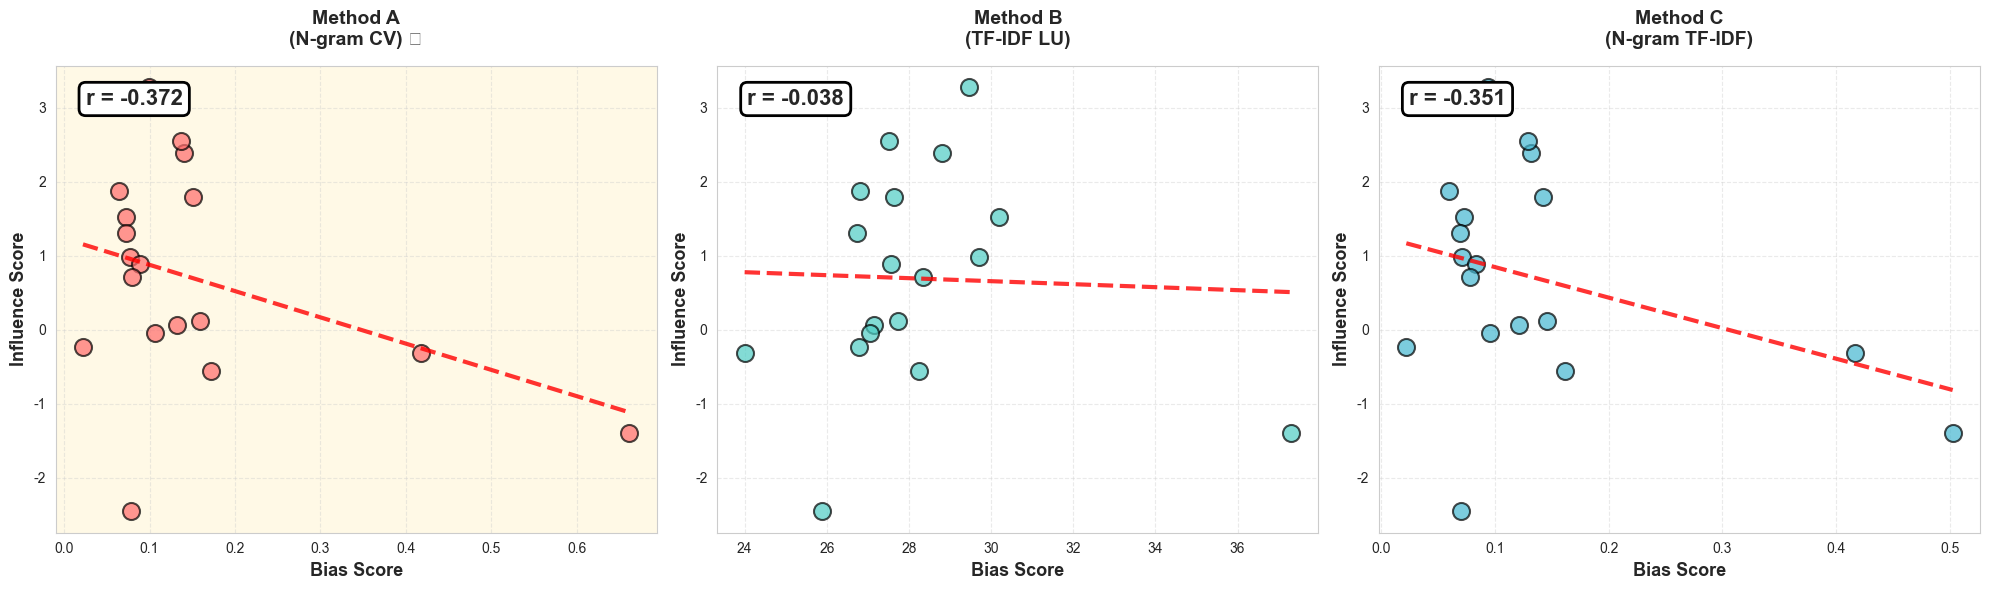

In [5]:
# Visualize correlations
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

methods_viz = [
    ('Method A\n(N-gram CV)', 'Bias_Score_A', corr_A, '#FF6B6B'),
    ('Method B\n(TF-IDF LU)', 'Bias_Score_B', corr_B, '#4ECDC4'),
    ('Method C\n(N-gram TF-IDF)', 'Bias_Score_C', corr_C, '#45B7D1')
]

for idx, (name, col, corr, color) in enumerate(methods_viz):
    ax = axes[idx]
    
    ax.scatter(df_all[col], df_all['Influence_Score'], 
               alpha=0.7, s=150, color=color, edgecolors='black', linewidths=1.5)
    
    z = np.polyfit(df_all[col], df_all['Influence_Score'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(df_all[col].min(), df_all[col].max(), 100)
    ax.plot(x_line, p(x_line), 'r--', linewidth=3, alpha=0.8)
    
    ax.set_xlabel('Bias Score', fontsize=13, fontweight='bold')
    ax.set_ylabel('Influence Score', fontsize=13, fontweight='bold')
    
    title = name
    if 'Method A' in name:
        title += ' ⭐'
        ax.set_facecolor('#fff9e6')
    
    ax.set_title(title, fontsize=14, fontweight='bold', pad=15)
    ax.text(0.05, 0.95, f'r = {corr:.3f}', transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='top',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='black', linewidth=2))
    ax.grid(True, alpha=0.4, linestyle='--')

plt.tight_layout()
plt.savefig('01_correlation_comparison.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: 01_correlation_comparison.png")
plt.show()

## 2.2 Distribution Analysis

In [6]:
# Statistical summary
print("="*80)
print("BIAS SCORE DISTRIBUTION STATISTICS")
print("="*80)

stats_list = []
for name, col in [('Method A', 'Bias_Score_A'), ('Method B', 'Bias_Score_B'), ('Method C', 'Bias_Score_C')]:
    data = df_all[col]
    stats = {
        'Method': name,
        'Mean': data.mean(),
        'Median': data.median(),
        'Std': data.std(),
        'Min': data.min(),
        'Max': data.max(),
        'Range': data.max() - data.min(),
        'CV': data.std() / data.mean() if data.mean() != 0 else np.nan
    }
    stats_list.append(stats)
    
    print(f"\n{name}:")
    print(f"  Mean:   {stats['Mean']:8.4f}")
    print(f"  Median: {stats['Median']:8.4f}")
    print(f"  Std:    {stats['Std']:8.4f}")
    print(f"  Range:  [{stats['Min']:.4f}, {stats['Max']:.4f}]")
    print(f"  CV:     {stats['CV']:8.4f}")

stats_df = pd.DataFrame(stats_list)
print("\n" + "="*80)

BIAS SCORE DISTRIBUTION STATISTICS

Method A:
  Mean:     0.1518
  Median:   0.1023
  Std:      0.1522
  Range:  [0.0221, 0.6614]
  CV:       1.0030

Method B:
  Mean:    28.1605
  Median:  27.5879
  Std:      2.7013
  Range:  [23.9994, 37.3026]
  CV:       0.0959

Method C:
  Mean:     0.1372
  Median:   0.0948
  Std:      0.1235
  Range:  [0.0221, 0.5024]
  CV:       0.9005




✓ Saved: 02_distribution_comparison.png


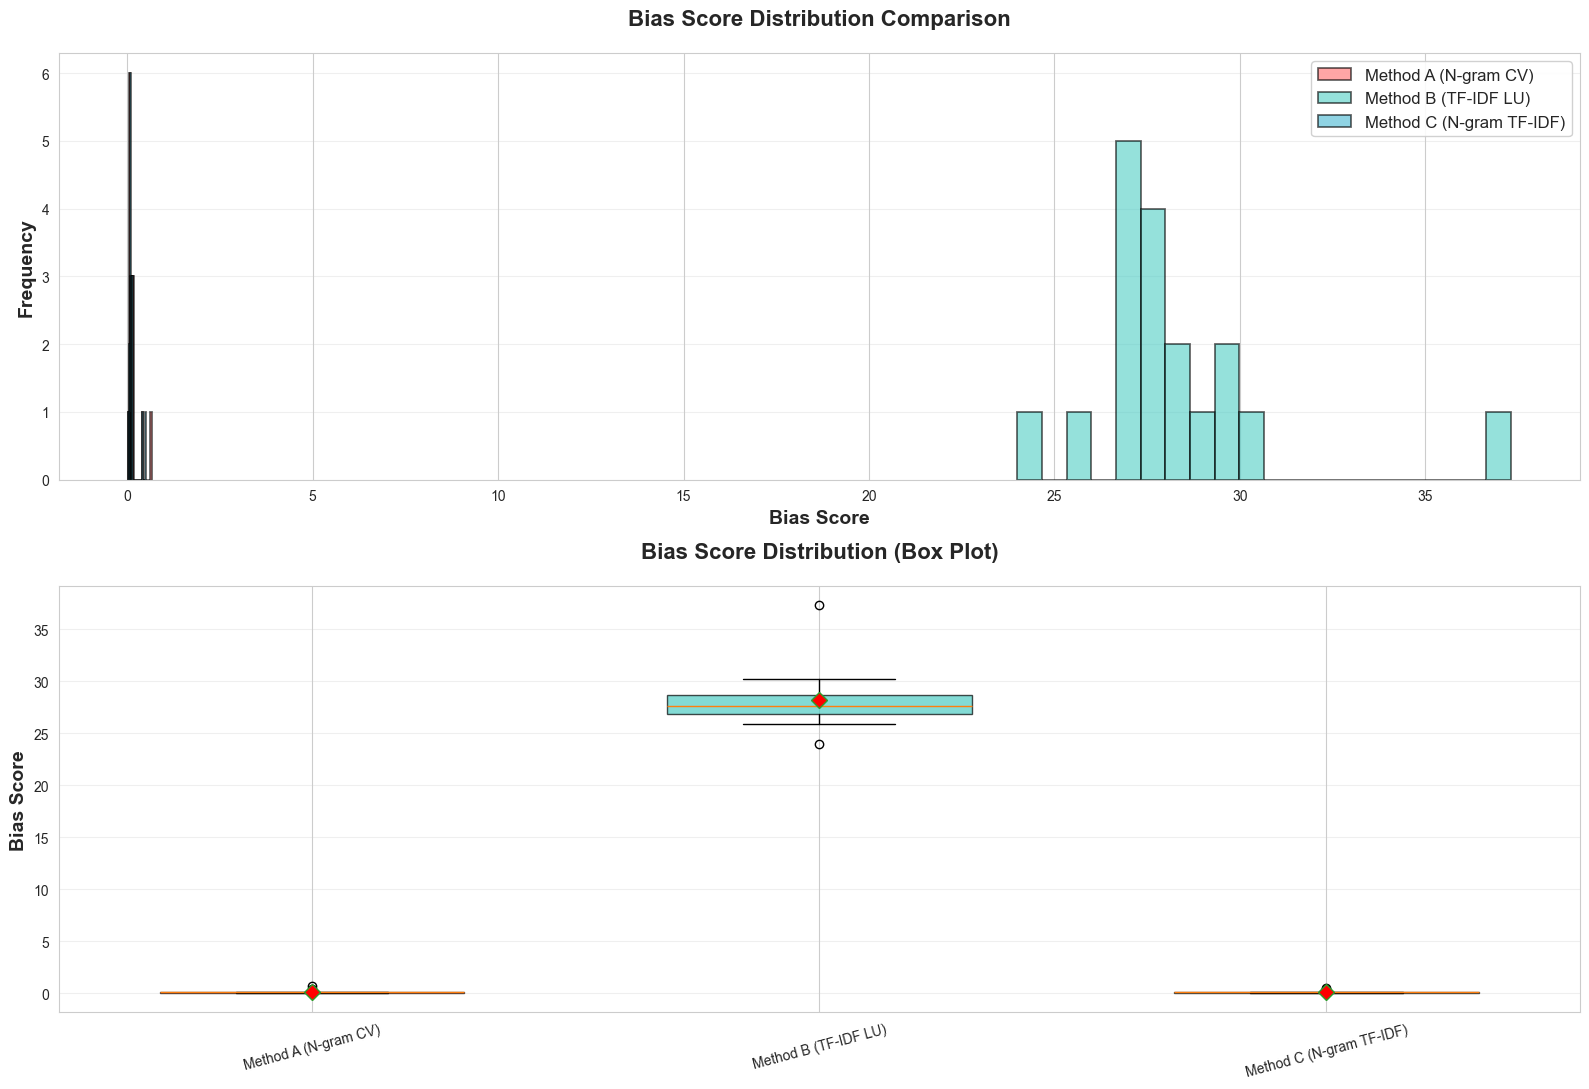

In [7]:
# Distribution visualizations
fig, axes = plt.subplots(2, 1, figsize=(16, 11))

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
labels = ['Method A (N-gram CV)', 'Method B (TF-IDF LU)', 'Method C (N-gram TF-IDF)']

# Histogram
ax1 = axes[0]
for col, color, label in zip(['Bias_Score_A', 'Bias_Score_B', 'Bias_Score_C'], colors, labels):
    ax1.hist(df_all[col], bins=20, alpha=0.6, label=label, 
             edgecolor='black', linewidth=1.3, color=color)

ax1.set_xlabel('Bias Score', fontsize=14, fontweight='bold')
ax1.set_ylabel('Frequency', fontsize=14, fontweight='bold')
ax1.set_title('Bias Score Distribution Comparison', fontsize=16, fontweight='bold', pad=20)
ax1.legend(fontsize=12, loc='upper right', framealpha=0.9)
ax1.grid(True, alpha=0.3, axis='y')

# Box plot
ax2 = axes[1]
data_to_plot = [df_all['Bias_Score_A'], df_all['Bias_Score_B'], df_all['Bias_Score_C']]
positions = [1, 2, 3]
bp = ax2.boxplot(data_to_plot, positions=positions, labels=labels, 
                  patch_artist=True, widths=0.6, showmeans=True, 
                  meanprops=dict(marker='D', markerfacecolor='red', markersize=8))

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax2.set_ylabel('Bias Score', fontsize=14, fontweight='bold')
ax2.set_title('Bias Score Distribution (Box Plot)', fontsize=16, fontweight='bold', pad=20)
ax2.grid(True, alpha=0.3, axis='y')
ax2.tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.savefig('02_distribution_comparison.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: 02_distribution_comparison.png")
plt.show()

## 2.3 Ranking Agreement

In [8]:
# Calculate rankings
df_all['Rank_A'] = df_all['Bias_Score_A'].rank(ascending=False)
df_all['Rank_B'] = df_all['Bias_Score_B'].rank(ascending=False)
df_all['Rank_C'] = df_all['Bias_Score_C'].rank(ascending=False)

# Spearman correlations
corr_AB, p_AB = spearmanr(df_all['Rank_A'], df_all['Rank_B'])
corr_AC, p_AC = spearmanr(df_all['Rank_A'], df_all['Rank_C'])
corr_BC, p_BC = spearmanr(df_all['Rank_B'], df_all['Rank_C'])

print("="*80)
print("RANKING AGREEMENT ANALYSIS (Spearman Correlation)")
print("="*80)
print(f"\nMethod A vs B: ρ = {corr_AB:.4f} (p = {p_AB:.4f})")
print(f"Method A vs C: ρ = {corr_AC:.4f} (p = {p_AC:.4f})")
print(f"Method B vs C: ρ = {corr_BC:.4f} (p = {p_BC:.4f})")

avg_agreement = np.mean([corr_AB, corr_AC, corr_BC])
print(f"\nAverage agreement: {avg_agreement:.4f}")

if avg_agreement > 0.7:
    print("→ HIGH agreement: Methods rank media consistently")
elif avg_agreement > 0.4:
    print("→ MODERATE agreement: Some consistency across methods")
else:
    print("→ LOW agreement: Methods produce divergent rankings")
print("="*80)

RANKING AGREEMENT ANALYSIS (Spearman Correlation)

Method A vs B: ρ = 0.1971 (p = 0.4331)
Method A vs C: ρ = 0.9856 (p = 0.0000)
Method B vs C: ρ = 0.2879 (p = 0.2466)

Average agreement: 0.4902
→ MODERATE agreement: Some consistency across methods


# PART 3: Clustering Algorithm Comparison

For each dictionary method (A, B, C), compare three clustering algorithms:
- K-Means
- Hierarchical (Agglomerative)
- DBSCAN

In [9]:
def find_optimal_k(X_scaled, k_range, method_name):
    """Find optimal K using multiple metrics"""
    silhouette_scores = []
    davies_bouldin_scores = []
    calinski_scores = []
    inertias = []
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_scaled)
        
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X_scaled, labels))
        davies_bouldin_scores.append(davies_bouldin_score(X_scaled, labels))
        calinski_scores.append(calinski_harabasz_score(X_scaled, labels))
    
    # Determine optimal K
    best_k_sil = k_range[np.argmax(silhouette_scores)]
    best_k_db = k_range[np.argmin(davies_bouldin_scores)]
    best_k_ch = k_range[np.argmax(calinski_scores)]
    
    print(f"\n{method_name} - Optimal K Analysis:")
    print(f"  By Silhouette Score: K = {best_k_sil} (score: {max(silhouette_scores):.4f})")
    print(f"  By Davies-Bouldin:   K = {best_k_db} (score: {min(davies_bouldin_scores):.4f})")
    print(f"  By Calinski-Harabasz: K = {best_k_ch} (score: {max(calinski_scores):.2f})")
    
    # Use Silhouette as primary
    optimal_k = best_k_sil
    print(f"  → Selected: K = {optimal_k} (based on Silhouette Score)")
    
    return optimal_k, {
        'silhouette': silhouette_scores,
        'davies_bouldin': davies_bouldin_scores,
        'calinski': calinski_scores,
        'inertia': inertias
    }

def apply_clustering_algorithms(X_scaled, optimal_k, method_name):
    """Apply three clustering algorithms and evaluate"""
    results = {}
    
    # K-Means
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    labels_km = kmeans.fit_predict(X_scaled)
    results['K-Means'] = {
        'labels': labels_km,
        'silhouette': silhouette_score(X_scaled, labels_km),
        'davies_bouldin': davies_bouldin_score(X_scaled, labels_km),
        'calinski': calinski_harabasz_score(X_scaled, labels_km),
        'n_clusters': optimal_k
    }
    
    # Hierarchical
    hierarchical = AgglomerativeClustering(n_clusters=optimal_k)
    labels_hc = hierarchical.fit_predict(X_scaled)
    results['Hierarchical'] = {
        'labels': labels_hc,
        'silhouette': silhouette_score(X_scaled, labels_hc),
        'davies_bouldin': davies_bouldin_score(X_scaled, labels_hc),
        'calinski': calinski_harabasz_score(X_scaled, labels_hc),
        'n_clusters': optimal_k
    }
    
    # DBSCAN
    from sklearn.neighbors import NearestNeighbors
    neighbors = NearestNeighbors(n_neighbors=4)
    neighbors_fit = neighbors.fit(X_scaled)
    distances, _ = neighbors_fit.kneighbors(X_scaled)
    distances = np.sort(distances[:, -1])
    eps_value = np.percentile(distances, 70)
    
    dbscan = DBSCAN(eps=eps_value, min_samples=2)
    labels_db = dbscan.fit_predict(X_scaled)
    
    n_clusters_db = len(set(labels_db)) - (1 if -1 in labels_db else 0)
    n_noise = list(labels_db).count(-1)
    
    if n_clusters_db > 1 and n_noise < len(X_scaled) * 0.3:
        mask = labels_db != -1
        if mask.sum() > 1:
            results['DBSCAN'] = {
                'labels': labels_db,
                'silhouette': silhouette_score(X_scaled[mask], labels_db[mask]),
                'davies_bouldin': davies_bouldin_score(X_scaled[mask], labels_db[mask]),
                'calinski': calinski_harabasz_score(X_scaled[mask], labels_db[mask]),
                'n_clusters': n_clusters_db,
                'n_noise': n_noise
            }
    
    # Print results
    print(f"\n{method_name} - Clustering Algorithm Performance:")
    print(f"{'Algorithm':<15} {'Silhouette':<12} {'Davies-Bouldin':<17} {'Calinski-H':<12} {'N_Clusters'}")
    print("-" * 80)
    
    for alg_name, metrics in results.items():
        print(f"{alg_name:<15} {metrics['silhouette']:<12.4f} {metrics['davies_bouldin']:<17.4f} "
              f"{metrics['calinski']:<12.2f} {metrics['n_clusters']}")
        if 'n_noise' in metrics:
            print(f"  └─ Noise points: {metrics['n_noise']}")
    
    # Determine best algorithm
    best_alg = max(results.items(), key=lambda x: x[1]['silhouette'])[0]
    print(f"\n  → BEST: {best_alg} (highest Silhouette Score)")
    
    return results, best_alg

print("✓ Helper functions defined")

✓ Helper functions defined


## 3.1 Method A: N-gram CountVectorizer

In [10]:
print("="*80)
print("METHOD A: N-gram CountVectorizer")
print("="*80)

# Prepare data
X_A = df_all[['Bias_Score_A', 'Influence_Score']].values
scaler_A = StandardScaler()
X_A_scaled = scaler_A.fit_transform(X_A)

# Find optimal K
k_range_A = range(2, min(8, len(df_all)))
optimal_k_A, metrics_A = find_optimal_k(X_A_scaled, k_range_A, "Method A")

# Apply clustering algorithms
results_A, best_alg_A = apply_clustering_algorithms(X_A_scaled, optimal_k_A, "Method A")

METHOD A: N-gram CountVectorizer

Method A - Optimal K Analysis:
  By Silhouette Score: K = 2 (score: 0.6026)
  By Davies-Bouldin:   K = 7 (score: 0.3236)
  By Calinski-Harabasz: K = 7 (score: 45.42)
  → Selected: K = 2 (based on Silhouette Score)

Method A - Clustering Algorithm Performance:
Algorithm       Silhouette   Davies-Bouldin    Calinski-H   N_Clusters
--------------------------------------------------------------------------------
K-Means         0.6026       0.5417            16.33        2
Hierarchical    0.6026       0.5417            16.33        2

  → BEST: K-Means (highest Silhouette Score)


## 3.2 Method B: TF-IDF lexical_units

In [11]:
print("\n" + "="*80)
print("METHOD B: TF-IDF lexical_units")
print("="*80)

X_B = df_all[['Bias_Score_B', 'Influence_Score']].values
scaler_B = StandardScaler()
X_B_scaled = scaler_B.fit_transform(X_B)

k_range_B = range(2, min(8, len(df_all)))
optimal_k_B, metrics_B = find_optimal_k(X_B_scaled, k_range_B, "Method B")

results_B, best_alg_B = apply_clustering_algorithms(X_B_scaled, optimal_k_B, "Method B")


METHOD B: TF-IDF lexical_units

Method B - Optimal K Analysis:
  By Silhouette Score: K = 2 (score: 0.6229)
  By Davies-Bouldin:   K = 2 (score: 0.2362)
  By Calinski-Harabasz: K = 7 (score: 36.31)
  → Selected: K = 2 (based on Silhouette Score)

Method B - Clustering Algorithm Performance:
Algorithm       Silhouette   Davies-Bouldin    Calinski-H   N_Clusters
--------------------------------------------------------------------------------
K-Means         0.6229       0.2362            11.62        2
Hierarchical    0.6229       0.2362            11.62        2

  → BEST: K-Means (highest Silhouette Score)


## 3.3 Method C: N-gram TF-IDF

In [12]:
print("\n" + "="*80)
print("METHOD C: N-gram TF-IDF")
print("="*80)

X_C = df_all[['Bias_Score_C', 'Influence_Score']].values
scaler_C = StandardScaler()
X_C_scaled = scaler_C.fit_transform(X_C)

k_range_C = range(2, min(8, len(df_all)))
optimal_k_C, metrics_C = find_optimal_k(X_C_scaled, k_range_C, "Method C")

results_C, best_alg_C = apply_clustering_algorithms(X_C_scaled, optimal_k_C, "Method C")


METHOD C: N-gram TF-IDF

Method C - Optimal K Analysis:
  By Silhouette Score: K = 2 (score: 0.6330)
  By Davies-Bouldin:   K = 7 (score: 0.3248)
  By Calinski-Harabasz: K = 7 (score: 42.70)
  → Selected: K = 2 (based on Silhouette Score)

Method C - Clustering Algorithm Performance:
Algorithm       Silhouette   Davies-Bouldin    Calinski-H   N_Clusters
--------------------------------------------------------------------------------
K-Means         0.6330       0.4169            17.77        2
Hierarchical    0.6330       0.4169            17.77        2

  → BEST: K-Means (highest Silhouette Score)


## 3.4 Summary of All Combinations

In [13]:
# Create comprehensive comparison table
all_results = []

for method, results_dict in [('Method A', results_A), ('Method B', results_B), ('Method C', results_C)]:
    for alg_name, metrics in results_dict.items():
        all_results.append({
            'Dictionary_Method': method,
            'Clustering_Algorithm': alg_name,
            'Silhouette_Score': metrics['silhouette'],
            'Davies_Bouldin_Index': metrics['davies_bouldin'],
            'Calinski_Harabasz_Score': metrics['calinski'],
            'N_Clusters': metrics['n_clusters']
        })

comparison_df = pd.DataFrame(all_results)

print("\n" + "="*80)
print("COMPREHENSIVE COMPARISON: All Method × Algorithm Combinations")
print("="*80)
print(comparison_df.to_string(index=False))

# Find overall best
best_idx = comparison_df['Silhouette_Score'].idxmax()
best_combo = comparison_df.loc[best_idx]

print("\n" + "="*80)
print("OVERALL BEST COMBINATION:")
print(f"  Dictionary: {best_combo['Dictionary_Method']}")
print(f"  Algorithm:  {best_combo['Clustering_Algorithm']}")
print(f"  Silhouette: {best_combo['Silhouette_Score']:.4f}")
print(f"  Davies-Bouldin: {best_combo['Davies_Bouldin_Index']:.4f}")
print("="*80)


COMPREHENSIVE COMPARISON: All Method × Algorithm Combinations
Dictionary_Method Clustering_Algorithm  Silhouette_Score  Davies_Bouldin_Index  Calinski_Harabasz_Score  N_Clusters
         Method A              K-Means          0.602590              0.541732                16.330467           2
         Method A         Hierarchical          0.602590              0.541732                16.330467           2
         Method B              K-Means          0.622932              0.236243                11.624332           2
         Method B         Hierarchical          0.622932              0.236243                11.624332           2
         Method C              K-Means          0.632981              0.416944                17.771568           2
         Method C         Hierarchical          0.632981              0.416944                17.771568           2

OVERALL BEST COMBINATION:
  Dictionary: Method C
  Algorithm:  K-Means
  Silhouette: 0.6330
  Davies-Bouldin: 0.4169


## 3.5 Export Results

In [14]:
# Save clustering results for each method
df_all['Cluster_A_KMeans'] = results_A['K-Means']['labels']
df_all['Cluster_A_Hierarchical'] = results_A['Hierarchical']['labels']
if 'DBSCAN' in results_A:
    df_all['Cluster_A_DBSCAN'] = results_A['DBSCAN']['labels']

df_all['Cluster_B_KMeans'] = results_B['K-Means']['labels']
df_all['Cluster_B_Hierarchical'] = results_B['Hierarchical']['labels']
if 'DBSCAN' in results_B:
    df_all['Cluster_B_DBSCAN'] = results_B['DBSCAN']['labels']

df_all['Cluster_C_KMeans'] = results_C['K-Means']['labels']
df_all['Cluster_C_Hierarchical'] = results_C['Hierarchical']['labels']
if 'DBSCAN' in results_C:
    df_all['Cluster_C_DBSCAN'] = results_C['DBSCAN']['labels']

# Export
df_all.to_csv('clustering_results.csv', index=False, encoding='utf-8-sig')
comparison_df.to_csv('comparison_metrics.csv', index=False, encoding='utf-8-sig')

print("\n✓ EXPORTED FILES:")
print("  - clustering_results.csv (all clustering labels for all methods)")
print("  - comparison_metrics.csv (performance metrics for all combinations)")
print(f"\n✓ Total rows: {len(df_all)}")
print(f"✓ Total columns: {len(df_all.columns)}")
print(f"\n✓ Columns: {df_all.columns.tolist()}")


✓ EXPORTED FILES:
  - clustering_results.csv (all clustering labels for all methods)
  - comparison_metrics.csv (performance metrics for all combinations)

✓ Total rows: 18
✓ Total columns: 14

✓ Columns: ['언론사', 'Bias_Score_A', 'Bias_Score_B', 'Bias_Score_C', 'Influence_Score', 'Rank_A', 'Rank_B', 'Rank_C', 'Cluster_A_KMeans', 'Cluster_A_Hierarchical', 'Cluster_B_KMeans', 'Cluster_B_Hierarchical', 'Cluster_C_KMeans', 'Cluster_C_Hierarchical']


# SUMMARY

In [15]:
print("\n" + "="*80)
print("PART 1 COMPLETE: DICTIONARY AND CLUSTERING COMPARISON")
print("="*80)

print("\n1. DICTIONARY METHOD COMPARISON")
print("-" * 80)
for method, corr in correlations.items():
    print(f"  {method:<30s} r = {corr:7.4f}")
print(f"\n  → Best: {best_method_name} (r = {best_corr:.4f})")

print("\n2. CLUSTERING ALGORITHM COMPARISON")
print("-" * 80)
print(f"  Method A best: {best_alg_A}")
print(f"  Method B best: {best_alg_B}")
print(f"  Method C best: {best_alg_C}")

print("\n3. OVERALL BEST COMBINATION")
print("-" * 80)
print(f"  Dictionary Method:    {best_combo['Dictionary_Method']}")
print(f"  Clustering Algorithm: {best_combo['Clustering_Algorithm']}")
print(f"  Silhouette Score:     {best_combo['Silhouette_Score']:.4f}")

print("\n4. OUTPUT FILES CREATED")
print("-" * 80)
print("  ✓ clustering_results.csv")
print("  ✓ comparison_metrics.csv")
print("  ✓ 01_correlation_comparison.png")
print("  ✓ 02_distribution_comparison.png")

print("\n5. NEXT STEPS")
print("-" * 80)
print("  → Run 'Final_Model_Selection.ipynb' to:")
print("     - Analyze best model in detail")
print("     - Generate comprehensive visualizations")
print("     - Extract key insights and findings")
print("     - Create report-ready outputs")

print("\n" + "="*80)
print("✓ ANALYSIS COMPLETE")
print("="*80)


PART 1 COMPLETE: DICTIONARY AND CLUSTERING COMPARISON

1. DICTIONARY METHOD COMPARISON
--------------------------------------------------------------------------------
  Method A (N-gram CV)           r = -0.3721
  Method B (TF-IDF LU)           r = -0.0376
  Method C (N-gram TF-IDF)       r = -0.3510

  → Best: Method A (N-gram CV) (r = -0.3721)

2. CLUSTERING ALGORITHM COMPARISON
--------------------------------------------------------------------------------
  Method A best: K-Means
  Method B best: K-Means
  Method C best: K-Means

3. OVERALL BEST COMBINATION
--------------------------------------------------------------------------------
  Dictionary Method:    Method C
  Clustering Algorithm: K-Means
  Silhouette Score:     0.6330

4. OUTPUT FILES CREATED
--------------------------------------------------------------------------------
  ✓ clustering_results.csv
  ✓ comparison_metrics.csv
  ✓ 01_correlation_comparison.png
  ✓ 02_distribution_comparison.png

5. NEXT STEPS
--------